In [1]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

In [2]:
concentration=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55]
dispense_rate=[0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
parameter_pool=[]
for i in range(len(concentration)):
    for j in range(len(concentration)):
        for n in range(len(dispense_rate)):
            parameter=[concentration[i],concentration[j],dispense_rate[n]]
            parameter_pool.append(parameter)

In [3]:
parameter_pool=np.array(parameter_pool)       
len(parameter_pool)

1452

In [4]:
data=pd.read_excel('result.xlsx')[0:27]
data

,Unnamed: 0,acid_concentration/M,metal_concentration/M,depense_rate,Unnamed: 4,phase/ 0 alpha/1 beta/2 mix,Unnamed: 6,Ibeta,Ialpha,Ialpha/Itotal
0,1,0.40,0.40,1.00,NaN,2,NaN,307.20,648.95,0.678714
1,2,0.40,0.20,1.00,NaN,2,NaN,2031.05,355.97,0.149126
2,3,0.40,0.05,1.00,NaN,1,NaN,NaN,NaN,0.000000
3,4,0.20,0.40,1.00,NaN,2,NaN,1090.34,821.90,0.429811
4,5,0.20,0.20,1.00,NaN,2,NaN,1980.52,379.70,0.160875
5,6,0.20,0.05,1.00,NaN,1,NaN,NaN,NaN,0.000000
6,7,0.05,0.40,1.00,NaN,1,NaN,NaN,NaN,0.000000
7,8,0.05,0.20,1.00,NaN,1,NaN,NaN,NaN,0.000000
8,9,0.05,0.05,1.00,NaN,1,NaN,NaN,NaN,0.000000
9,10,0.40,0.40,0.20,NaN,2,NaN,4449.72,452.86,0.092372


In [5]:
X=data.iloc[:,1:4]

In [6]:
X=np.array(X)

In [7]:

parameter_pool_tuples = [tuple(row) for row in parameter_pool]
X_tuples = set(tuple(row) for row in X)

sample_unlabeled = np.array([row for row in parameter_pool_tuples if row not in X_tuples])


In [8]:
Y=data[['Ialpha/Itotal']]

In [9]:
Y=np.array(Y).ravel()

In [10]:
y=np.array(data[['phase/ 0 alpha/1 beta/2 mix']])

In [11]:
y

array([[2],
       [2],
       [1],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [1],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [1],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [12]:


kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1)

gpr = GaussianProcessRegressor(kernel=kernel,random_state=42)

In [13]:
gpr.fit(X, Y)

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         random_state=42)

In [14]:
def expected_improvement(X, gpr, y_best, xi):
    mu, sigma = gpr.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    mu = mu.reshape(-1, 1)

    with np.errstate(divide='warn'):
        imp = mu - y_best - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei.ravel()

[[0.55 0.55 1.  ]
 [0.5  0.55 1.  ]
 [0.45 0.55 1.  ]
 [0.55 0.55 0.9 ]
 [0.5  0.55 0.9 ]
 [0.4  0.55 1.  ]
 [0.55 0.5  1.  ]
 [0.45 0.55 0.9 ]
 [0.5  0.5  1.  ]
 [0.45 0.5  1.  ]
 [0.55 0.55 0.8 ]
 [0.4  0.55 0.9 ]
 [0.35 0.55 1.  ]
 [0.55 0.5  0.9 ]
 [0.5  0.55 0.8 ]
 [0.5  0.5  0.9 ]
 [0.4  0.5  1.  ]
 [0.45 0.55 0.8 ]
 [0.45 0.5  0.9 ]
 [0.35 0.55 0.9 ]]


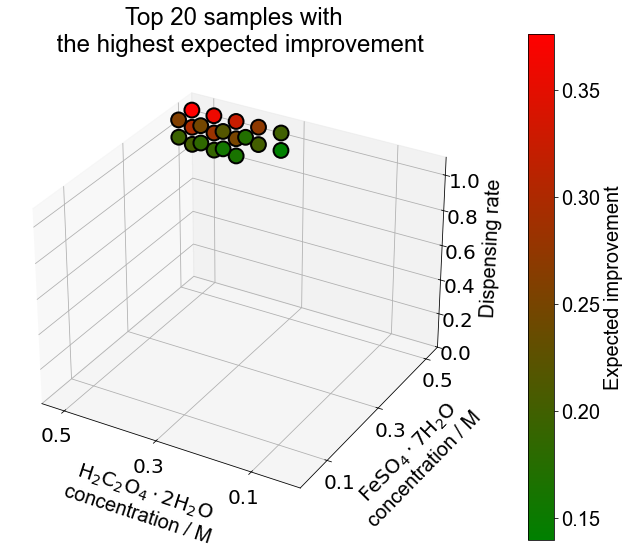

In [15]:
ei_all=expected_improvement(sample_unlabeled, gpr, np.max(Y), 0.01)
top_k = 20
top_ei_indices = np.argsort(ei_all)[-top_k:][::-1]
top_ei_sampls=sample_unlabeled[top_ei_indices]
top_ei=ei_all[top_ei_indices]
print(top_ei_sampls)
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FixedLocator
from matplotlib import font_manager as fm
import matplotlib as mpl
from matplotlib.colors import PowerNorm



custom_cmap = LinearSegmentedColormap.from_list("green_to_red", ["green", "red"])
fig = plt.figure(figsize=(9, 12))

ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    top_ei_sampls[:, 0], top_ei_sampls[:, 1], top_ei_sampls[:, 2],
     c=top_ei, cmap=custom_cmap, #norm=norm,
   
    s=220, edgecolors='black', linewidths=2,
    alpha=1.0
)

# Set tick positions
xticks = np.arange(0.1, 0.55, 0.2)
yticks = np.arange(0.1, 0.55, 0.2)
zticks = np.arange(0, 1.05, 0.2)

ax.xaxis.set_major_locator(FixedLocator(xticks))
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.zaxis.set_major_locator(FixedLocator(zticks))

# Set tick params for consistent font
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='z', labelsize=20)

# Set font family for tick labels using rcParams or font_manager (font family does not always apply in 3D ticks)
# Alternative: set font globally

mpl.rcParams['font.family'] = 'Arial'

# Axis labels (fontname Arial)
ax.set_xlabel(r'$\mathrm{H_2C_2O_4 \cdot 2H_2O}$' + '\n' + 'concentration / M', 
              fontsize=20, fontname='Arial', labelpad=20)

ax.set_ylabel(r'$\mathrm{FeSO_4 \cdot 7H_2O}$' + '\n' + 'concentration / M', 
              fontsize=20, fontname='Arial', labelpad=20)
ax.set_zlabel('Dispensing rate', fontsize=20, fontname='Arial',labelpad=10)

ax.set_xlim(0.55, 0)
ax.set_ylim(0, 0.55)
ax.set_zlim(0, 1.1)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(r"Expected improvement", fontsize=20, fontname='Arial')

plt.tight_layout()
plt.title("Top 20 samples with \n the highest expected improvement", fontsize=24, fontname='Arial')

plt.savefig("top_20_ei.png", dpi=300)
plt.show()


In [16]:
import numpy as np
from scipy.stats import norm
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler





def select_batch_points(X_candidates, gpr, Y, batch_size, min_distance, xi):
    y_best = np.max(Y)
    selected = []
    available = X_candidates.copy()

    for _ in range(batch_size):
        if len(available) == 0:
            break

        ei = expected_improvement(available, gpr, y_best, xi)
        if np.all(ei <= 0):
            break

        idx = np.argmax(ei)
        chosen = available[idx]
        selected.append(chosen)

        selected_array = np.vstack(selected)
        dists = np.min(cdist(available, selected_array),axis=1)
        
       
        
        mask =  (dists >= min_distance)
        available = available[mask]

    return np.array(selected)


next_points = select_batch_points(
    sample_unlabeled,  
    gpr,
    Y,
    batch_size=3,
    min_distance=0.3, 
    xi=0.01
)

print("Next batch points with min distance > 0.3:\n", next_points)


Next batch points with min distance > 0.3:
 [[0.55 0.55 1.  ]
 [0.55 0.55 0.7 ]
 [0.25 0.55 1.  ]]


In [17]:

def penalized_ei(X_candidates, gpr, y_best, selected_batch, xi):
    ei = expected_improvement(X_candidates, gpr, y_best, xi)
   
    

    if len(selected_batch) == 0:
        return ei

   
    dists = cdist(X_candidates, np.array(selected_batch))
    
   
    penalties = np.min(dists, axis=1).reshape(-1, 1) 
    
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    penalties = scaler.fit_transform(penalties)
    

    penalized_ei = ei * penalties.ravel()
   
    return penalized_ei

def select_batch_points_w_penalty(X_candidates, gpr, Y, batch_size, min_distance, xi):
    y_best = np.max(Y)
    selected = []
    available = X_candidates.copy()

    for _ in range(batch_size):
        if len(available) == 0:
            break

        ei_pen = penalized_ei(available, gpr, y_best, selected,  xi)
        if np.all(ei_pen <= 0):
            break

        idx = np.argmax(ei_pen)
        chosen = available[idx]
        selected.append(chosen)

     
        
        selected_array = np.vstack(selected)
        dists = np.min(cdist(available, selected_array),axis=1)
        
       
        
        mask =  (dists >= min_distance)
        available = available[mask]

    return np.array(selected_array)


next_points = select_batch_points_w_penalty(
    sample_unlabeled,  
    gpr,
    Y,
    batch_size=3,
    min_distance=0.3,  
    xi=0.01
)

print("Next batch points with additional penalty:\n", next_points)


Next batch points with additional penalty:
 [[0.55 0.55 1.  ]
 [0.55 0.55 0.6 ]
 [0.3  0.55 0.8 ]]
